In [59]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.colors import n_colors
from scipy.stats import norm
import numpy as np
import pandas as pd
from functools import partial

In [60]:
def gaussian(xaxis, A, B, mu, sigma):
    y = B * (1 - norm(loc=mu, scale=sigma).cdf(xaxis) + A) 
    return y

In [61]:
from doepy import build

In [62]:
def generate_dataset(num_samples=1000):
    # levels = {'A': [1, 3], 'B': [0, 1], 'mu': [-2, 2], 'sigma': [0.2, 4]}
    levels = {'B': [1, 3], 'mu': [-2, 2], 'sigma': [0.2, 4]}
    xaxis = np.linspace(-4, 4)

    samples_params = build.space_filling_lhs(levels, num_samples=num_samples)

    Y = pd.DataFrame([gaussian(xaxis, 1e-2, *row) for row in samples_params.itertuples(index=False)])
    return Y

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

In [64]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

In [65]:
Y = generate_dataset()
train, test = train_test_split(Y, test_size=0.5)
scaler = StandardScaler()
train_std = scaler.fit_transform(train)

In [66]:
import tensorflow.keras as K

In [67]:
class GANMonitor(K.callbacks.Callback):
    def __init__(self, figure_widget):
        self.figure_widget = figure_widget
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            with self.figure_widget.batch_update():
                c_trace, g_trace = self.figure_widget.data
                x = list(c_trace.x)
                x.append(x[-1]+1 if len(x) > 0 else 1)

                y1 = list(c_trace.y)
                y1.append(logs['d_loss'])

                y2 = list(g_trace.y)
                y2.append(logs['g_loss'])

                c_trace.x = x
                c_trace.y = y1
                g_trace.x = x
                g_trace.y = y2


In [68]:
%load_ext autoreload
%autoreload 2

from GAN import LSGAN
from tensorflow.keras.optimizers import RMSprop

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
# generator_optimizer = Adam(
#     learning_rate=1e-5, 
    # beta_1=0.5, beta_2=0.9
# )
# discriminator_optimizer = Adam(
#     learning_rate=1e-5, 
#beta_1=0.5, beta_2=0.9
# )

layers = (128, 64, 32, 16)
model = LSGAN(train_std.shape[1], 8, layers, layers[::-1],
               activation='selu', critic_extra_steps=3,
               critic_dropout=None, generator_dropout=None)

generator_optimizer = RMSprop(1e-5)
discriminator_optimizer = RMSprop(1e-5)
model.compile(discriminator_optimizer, generator_optimizer)

BATCH_SIZE = 500
fig = go.FigureWidget(
    [
        go.Scatter(x=[], y=[], name='critic'),
        go.Scatter(x=[], y=[], name='generator')
    ]
)

callback = GANMonitor(fig)
fig

FigureWidget({
    'data': [{'name': 'critic', 'type': 'scatter', 'uid': '91b8f569-65f0-43fb-9c02-8bfbc7b08658…

In [70]:
generator_optimizer = RMSprop(1e-5)
discriminator_optimizer = RMSprop(1e-5)
model.compile(discriminator_optimizer, generator_optimizer)

In [72]:
epochs = 10
model.fit(train_std, epochs=epochs, callbacks=[callback])

Epoch 1/10
16/16 [==============================] - 0s 6ms/step - d_loss: 0.4911 - g_loss: 0.4447
Epoch 2/10
16/16 [==============================] - 0s 5ms/step - d_loss: 0.4861 - g_loss: 0.4532
Epoch 3/10
16/16 [==============================] - 0s 5ms/step - d_loss: 0.4215 - g_loss: 0.5059
Epoch 4/10
16/16 [==============================] - 0s 5ms/step - d_loss: 0.4405 - g_loss: 0.5388
Epoch 5/10
16/16 [==============================] - 0s 4ms/step - d_loss: 0.3756 - g_loss: 0.5732
Epoch 6/10
16/16 [==============================] - 0s 5ms/step - d_loss: 0.3398 - g_loss: 0.6145
Epoch 7/10
16/16 [==============================] - 0s 5ms/step - d_loss: 0.3051 - g_loss: 0.5934
Epoch 8/10
16/16 [==============================] - 0s 5ms/step - d_loss: 0.3060 - g_loss: 0.6864
Epoch 9/10
16/16 [==============================] - 0s 5ms/step - d_loss: 0.2881 - g_loss: 0.7021
Epoch 10/10
16/16 [==============================] - 0s 5ms/step - d_loss: 0.2527 - g_loss: 0.7151


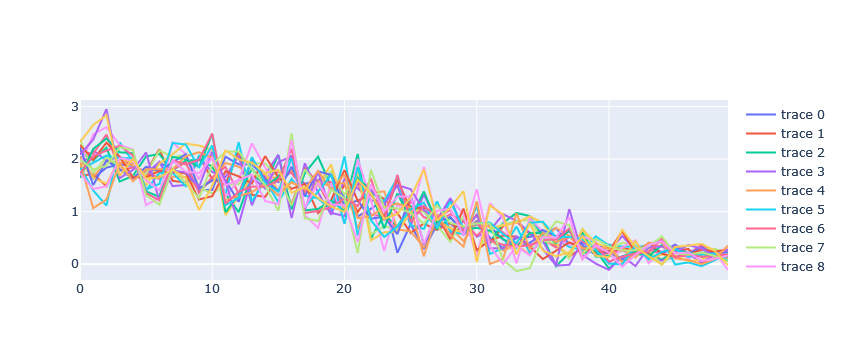

In [73]:
fig = go.Figure()
for row in scaler.inverse_transform(model.generator(np.random.randn(20, model.latent_dim)).numpy()):
    fig.add_scatter(y=row)
fig

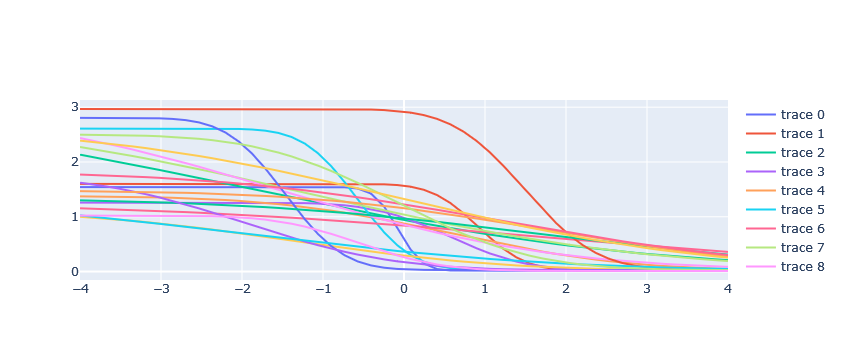

In [74]:
fig = go.Figure()
for _, row in X.sample(20).iterrows():
    xaxis = np.linspace(-4, 4)
    fig.add_scatter(x=xaxis, y=gaussian(xaxis, 1e-2, row.B, row.mu, row.sigma))
fig

In [ ]:
fake = model.generator(random_latent_vectors)

In [ ]:
tmp = Y.loc[0:1].values

In [ ]:
model.gradient_penalty(2, tmp, fake)